<a href="https://colab.research.google.com/github/koseoyoung/Informer2020/blob/main/Informer_with_netflow_multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Informer Demo

## Download code and dataset

In [150]:
!git clone https://github.com/zhouhaoyi/Informer2020.git
!git clone https://github.com/zhouhaoyi/ETDataset.git
!ls

fatal: destination path 'Informer2020' already exists and is not an empty directory.
fatal: destination path 'ETDataset' already exists and is not an empty directory.
ETDataset  Informer2020  informer_checkpoints  results	sample_data


In [151]:
import sys
if not 'Informer2020' in sys.path:
    sys.path += ['Informer2020']

In [152]:
# !pip install -r ./Informer2020/requirements.txt

## Experiments: Train and Test (ETT dataset)

In [3]:
from utils.tools import dotdict
from exp.exp_informer import Exp_Informer
import torch

This is a script to change the original ETT dataset (for experiments, e.g., change the date feature) 

In [4]:
import csv
import random

# Open the CSV file
with open('./ETDataset/ETT-small/ETTh1.csv', 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)

time_index = rows[0].index('date')
hull_index = rows[0].index('MUFL')


for i, row in enumerate(rows):
    converted = ''
    if i == 0: 
        converted = 'date'
    else: 
       converted = "2016-07-01 00:00:00"
       row[hull_index] = random.choice(["52", "1450"])

    row[time_index] = converted
  

# Write the updated rows to a new CSV file
with open('./sample_data/updated_ett.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)

In [127]:
args = dotdict()

args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]

args.data = 'ETTh1' # data
args.root_path = './ETDataset/ETT-small/' # root path of data file
args.data_path = 'ETTh1.csv' # data file
# args.data = 'custom' # data
# args.root_path = './sample_data/' # root path of data file
# args.data_path = 'updated_ett.csv' # data file
args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT' # target feature in S or MS task
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0
args.freq = 'h'

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'

args.use_gpu = True if torch.cuda.is_available() else False
args.gpu = 0

args.use_multi_gpu = False
args.devices = '0,1,2,3'


In [128]:
import pandas as pd
import os 
df = pd.read_csv(os.path.join(args.root_path, args.data_path))
df.head(10)

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000
5,2016-07-01 05:00:00,5.626,2.143,1.528,0.533,4.051,1.371,21.174000
6,2016-07-01 06:00:00,7.167,2.947,2.132,0.782,5.026,1.858,22.792000
7,2016-07-01 07:00:00,7.435,3.282,2.310,1.031,5.087,2.224,23.143999
8,2016-07-01 08:00:00,5.559,3.014,2.452,1.173,2.955,1.432,21.667000
9,2016-07-01 09:00:00,4.555,2.545,1.919,0.817,2.680,1.371,17.445999


In [129]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ','')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

In [130]:
# Set augments by using data name
data_parser = {
    'ETTh1':{'data':'ETTh1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTh2':{'data':'ETTh2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm1':{'data':'ETTm1.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
    'ETTm2':{'data':'ETTm2.csv','T':'OT','M':[7,7,7],'S':[1,1,1],'MS':[7,7,1]},
}
if args.data in data_parser.keys():
    data_info = data_parser[args.data]
    args.data_path = data_info['data']
    args.target = data_info['T']
    args.enc_in, args.dec_in, args.c_out = data_info[args.features]

In [165]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [131]:
print('Args in experiment:')
print(args)

Args in experiment:
{'model': 'informer', 'data': 'ETTh1', 'root_path': './ETDataset/ETT-small/', 'data_path': 'ETTh1.csv', 'features': 'M', 'target': 'OT', 'freq': 'h', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3'}


In [132]:
Exp = Exp_Informer

for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp = Exp(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 8521
val 2857
test 2857
	iters: 100, epoch: 1 | loss: 0.3923202
	speed: 0.0728s/iter; left time: 108.9960s
	iters: 200, epoch: 1 | loss: 0.3173462
	speed: 0.0720s/iter; left time: 100.5485s
Epoch: 1 cost time: 19.32886004447937
Epoch: 1, Steps: 266 | Train Loss: 0.4110771 Vali Loss: 0.6611637 Test Loss: 0.5376952
Validation loss decreased (inf --> 0.661164).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.2485272
	speed: 0.1684s/iter; left time: 207.2394s
	iters: 200, epoch: 2 | loss: 0.2507716
	speed: 0.0734s/iter; left time: 82.9894s
Epoch: 2 cost time: 19.594423055648804
Epoch: 2, Steps: 266 | Train Loss: 0.2599843 Vali Loss: 0.6805657 Test Loss: 0.5927439
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
	iters: 100, epoch: 3 | loss: 0.2001707
	speed: 0.1712s/iter;

## Experiments: Train and Test (urg16)


In [153]:
from data.data_loader import Dataset_Custom
from torch.utils.data import DataLoader
import pandas as pd
import os

In [154]:
# custom data: xxx.csv
# data features: ['date', ...(other features), target feature]

# we take ETTh2 as an example
args.root_path = './sample_data/'
args.data_path = 'updated_urg16.csv'
# args.root_path = './ETDataset/ETT-small/'
# args.data_path = 'ETTh2.csv'

df = pd.read_csv(os.path.join(args.root_path, args.data_path))

In [193]:
cols = list(df.columns); cols.remove(args.target); cols.remove('date')
print(cols)

df_raw = df[['date']+cols+[args.target]]
df_raw.head(10)

['dstip', 'srcport', 'dstport', 'srcip', 'pkt', 'byt']


,date,dstip,srcport,dstport,srcip,pkt,byt,td
0,2016-04-06 17:16:27,719034713,5938,62111,710619707,4689,917083,312.972
1,2016-04-06 17:16:27,3543491421,21,35123,719036242,64,5218,310.584
2,2016-04-06 17:16:29,719036342,0,0,707248946,1729,290596,308.108
3,2016-04-06 17:16:29,707248946,0,0,719036342,1933,1335085,308.004
4,2016-04-06 17:16:30,719035635,58679,40004,3642343491,33,1856,304.740
5,2016-04-06 17:16:30,604304074,1818,443,719036116,72,15480,300.384
6,2016-04-06 17:16:30,3104091342,59860,443,719034713,42,20286,300.288
7,2016-04-06 17:16:30,719035635,51787,40003,3627788584,32,1792,301.280
8,2016-04-06 17:16:30,719035635,39528,22001,3747623400,32,1792,301.236
9,2016-04-06 17:16:30,3234563910,64105,17771,719036116,42,4620,300.200


In [190]:
df.head(20)

,date,dstip,srcport,dstport,srcip,td,pkt,byt
0,2016-04-06 17:16:27,719034713,5938,62111,710619707,312.972,4689,917083
1,2016-04-06 17:16:27,3543491421,21,35123,719036242,310.584,64,5218
2,2016-04-06 17:16:29,719036342,0,0,707248946,308.108,1729,290596
3,2016-04-06 17:16:29,707248946,0,0,719036342,308.004,1933,1335085
4,2016-04-06 17:16:30,719035635,58679,40004,3642343491,304.740,33,1856
5,2016-04-06 17:16:30,604304074,1818,443,719036116,300.384,72,15480
6,2016-04-06 17:16:30,3104091342,59860,443,719034713,300.288,42,20286
7,2016-04-06 17:16:30,719035635,51787,40003,3627788584,301.280,32,1792
8,2016-04-06 17:16:30,719035635,39528,22001,3747623400,301.236,32,1792
9,2016-04-06 17:16:30,3234563910,64105,17771,719036116,300.200,42,4620


In [168]:
'''
We set 'HULL' as target instead of 'OT'

The following frequencies are supported:
        Y   - yearly
            alias: A
        M   - monthly
        W   - weekly
        D   - daily
        B   - business days
        H   - hourly
        T   - minutely
            alias: min
        S   - secondly
'''

args.target = 'td'
args.freq = 's'
args.data = "custom"

args.seq_len = 96 # input sequence length of Informer encoder
args.label_len = 48 # start token length of Informer decoder
args.pred_len = 24 # prediction sequence length
# Informer decoder input: concat[start token series(label_len), zero padding series(pred_len)]

args.enc_in = 7 # encoder input size
args.dec_in = 7 # decoder input size
args.c_out = 7 # output size
args.factor = 5 # probsparse attn factor
args.d_model = 512 # dimension of model
args.n_heads = 8 # num of heads
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.d_ff = 2048 # dimension of fcn in model
args.dropout = 0.05 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = 0

args.batch_size = 32 
args.learning_rate = 0.0001
args.loss = 'mse'
args.lradj = 'type1'
args.use_amp = False # whether to use automatic mixed precision training

args.num_workers = 0
args.itr = 1
args.train_epochs = 6
args.patience = 3
args.des = 'exp'
args.features = 'M'

Data = Dataset_Custom
timeenc = 0 if args.embed!='timeF' else 1
flag = 'test'; shuffle_flag = False; drop_last = True; batch_size = 1

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    timeenc=timeenc,
    target=args.target, # HULL here
    freq=args.freq # 'h': hourly, 't':minutely
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

In [169]:
batch_x,batch_y,batch_x_mark,batch_y_mark = data_set[0]
print (batch_x.shape)
print (batch_y.shape)
print (batch_x_mark.shape)

(96, 7)
(72, 7)
(96, 6)


In [170]:
args.detail_freq = args.freq
args.freq = args.freq[-1:]

In [171]:
print(args)

{'model': 'informer', 'data': 'custom', 'root_path': './sample_data/', 'data_path': 'updated_urg16.csv', 'features': 'M', 'target': 'td', 'freq': 's', 'checkpoints': './informer_checkpoints', 'seq_len': 96, 'label_len': 48, 'pred_len': 24, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'output_attention': False, 'mix': True, 'padding': 0, 'batch_size': 32, 'learning_rate': 0.0001, 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'num_workers': 0, 'itr': 1, 'train_epochs': 6, 'patience': 3, 'des': 'exp', 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'detail_freq': 's'}


In [172]:
Exp2 = Exp_Informer

In [173]:
for ii in range(args.itr):
    # setting record of experiments
    setting = '{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_at{}_fc{}_eb{}_dt{}_mx{}_{}_{}'.format(args.model, args.data, args.features, 
                args.seq_len, args.label_len, args.pred_len,
                args.d_model, args.n_heads, args.e_layers, args.d_layers, args.d_ff, args.attn, args.factor, args.embed, args.distil, args.mix, args.des, ii)

    # set experiments
    exp2 = Exp2(args)
    
    # train
    print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
    exp2.train(setting)
    
    # test
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp2.test(setting)

    torch.cuda.empty_cache()

Use GPU: cuda:0
>>>>>>>start training : informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0>>>>>>>>>>>>>>>>>>>>>>>>>>
train 9848
val 1402
test 2824
	iters: 100, epoch: 1 | loss: 0.6423217
	speed: 0.0762s/iter; left time: 132.8674s
	iters: 200, epoch: 1 | loss: 0.5748969
	speed: 0.0769s/iter; left time: 126.3568s
	iters: 300, epoch: 1 | loss: 0.5828327
	speed: 0.0780s/iter; left time: 120.2811s
Epoch: 1 cost time: 23.700514316558838
Epoch: 1, Steps: 307 | Train Loss: 0.8872429 Vali Loss: 0.5684129 Test Loss: 0.5782682
Validation loss decreased (inf --> 0.568413).  Saving model ...
Updating learning rate to 0.0001
	iters: 100, epoch: 2 | loss: 0.5523842
	speed: 0.1217s/iter; left time: 174.8292s
	iters: 200, epoch: 2 | loss: 0.5554458
	speed: 0.0785s/iter; left time: 104.8294s
	iters: 300, epoch: 2 | loss: 3.8018532
	speed: 0.0781s/iter; left time: 96.5621s
Epoch: 2 cost time: 24.09298872947693
Epoch: 2, Steps: 307 | Train Loss: 0.8361954 Va

## Predict (urg16) 

In [174]:
import os

# set saved model path
setting = 'informer_custom_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'
# setting = 'informer_ETTh1_ftM_sl96_ll48_pl24_dm512_nh8_el2_dl1_df2048_atprob_fc5_ebtimeF_dtTrue_mxTrue_exp_0'

# path = os.path.join(args.checkpoints,setting,'checkpoint.pth')

In [175]:
# If you already have a trained model, you can set the arguments and model path, then initialize a Experiment and use it to predict
# Prediction is a sequence which is adjacent to the last date of the data, and does not exist in the data
# If you want to get more information about prediction, you can refer to code `exp/exp_informer.py function predict()` and `data/data_loader.py class Dataset_Pred`
exp = Exp(args)
exp.predict(setting, True)

Use GPU: cuda:0
pred 1


In [176]:
# the prediction will be saved in ./results/{setting}/real_prediction.npy
import numpy as np

prediction = np.load('./results/'+setting+'/real_prediction.npy')

prediction.shape

(1, 24, 7)

### More details about Prediction - prediction function

In [177]:
# here is the detailed code of function predict

def predict(exp, setting, load=False):
    pred_data, pred_loader = exp._get_data(flag='pred')
        
    if load:
        path = os.path.join(exp.args.checkpoints, setting)
        best_model_path = path+'/'+'checkpoint.pth'
        exp.model.load_state_dict(torch.load(best_model_path))

    exp.model.eval()
        
    preds = []
        
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        # decoder input
        if exp.args.padding==0:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        elif exp.args.padding==1:
            dec_inp = torch.ones([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        else:
            dec_inp = torch.zeros([batch_y.shape[0], exp.args.pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:exp.args.label_len,:], dec_inp], dim=1).float().to(exp.device)
        # encoder - decoder
        if exp.args.use_amp:
            with torch.cuda.amp.autocast():
                if exp.args.output_attention:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
                else:
                    outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        else:
            if exp.args.output_attention:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)[0]
            else:
                outputs = exp.model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        f_dim = -1 if exp.args.features=='MS' else 0
        batch_y = batch_y[:,-exp.args.pred_len:,f_dim:].to(exp.device)
        
        pred = outputs.detach().cpu().numpy()#.squeeze()
        
        preds.append(pred)

    preds = np.array(preds)
    preds = preds.reshape(-1, preds.shape[-2], preds.shape[-1])
    
    # result save
    folder_path = './results/' + setting +'/'
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    np.save(folder_path+'real_prediction.npy', preds)
    
    return preds


In [178]:
# you can also use this prediction function to get result
prediction = predict(exp, setting, True)

pred 1


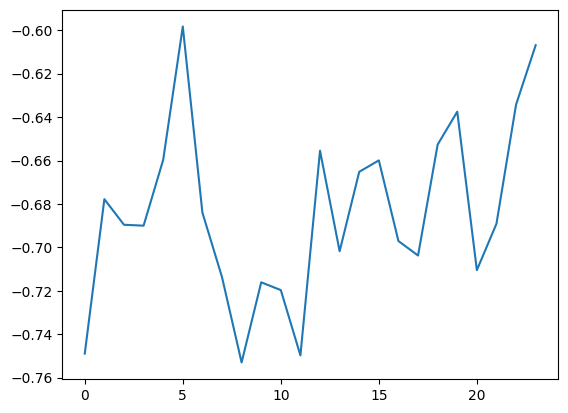

In [179]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(prediction[0,:,-1])
plt.show()

### More details about Prediction - prediction dataset

You can give a `root_path` and `data_path` of the data you want to forecast, and set `seq_len`, `label_len`, `pred_len` and other arguments as other Dataset. The difference is that you can set a more detailed freq such as `15min` or `3h` to generate the timestamp of prediction series.

`Dataset_Pred` only has one sample (including `encoder_input: [1, seq_len, dim]`, `decoder_token: [1, label_len, dim]`, `encoder_input_timestamp: [1, seq_len, date_dim]`, `decoder_input_timstamp: [1, label_len+pred_len, date_dim]`). It will intercept the last sequence of the given data (seq_len data) to forecast the unseen future sequence (pred_len data).

In [ ]:
from data.data_loader import Dataset_Pred
from torch.utils.data import DataLoader

In [ ]:
Data = Dataset_Pred
timeenc = 0 if args.embed!='timeF' else 1
flag = 'pred'; shuffle_flag = False; drop_last = False; batch_size = 1

freq = 's'
print(freq)

data_set = Data(
    root_path=args.root_path,
    data_path=args.data_path,
    flag=flag,
    size=[args.seq_len, args.label_len, args.pred_len],
    features=args.features,
    target=args.target,
    timeenc=timeenc,
    freq=freq
)
data_loader = DataLoader(
    data_set,
    batch_size=batch_size,
    shuffle=shuffle_flag,
    num_workers=args.num_workers,
    drop_last=drop_last)

s


In [ ]:
len(data_set), len(data_loader)

(1, 1)

## Visualization (urg16)

In [180]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

preds = np.load('./results/'+setting+'/pred.npy')
trues = np.load('./results/'+setting+'/true.npy')

# [samples, pred_len, dimensions]
preds.shape, trues.shape

((2816, 24, 7), (2816, 24, 7))

In [181]:
import matplotlib.pyplot as plt
import seaborn as sns

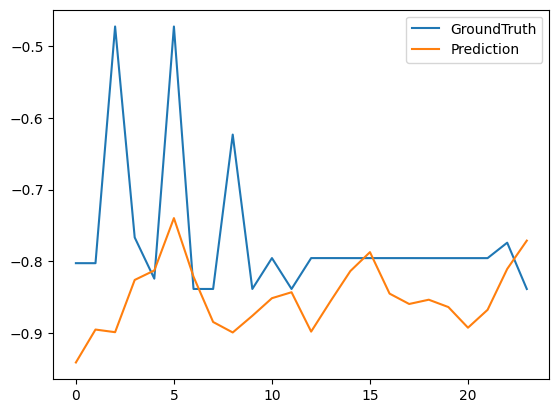

In [194]:
# draw td prediction
plt.figure()
plt.plot(trues[0,:,-1], label='GroundTruth')
plt.plot(preds[0,:,-1], label='Prediction')
plt.legend()
plt.show()

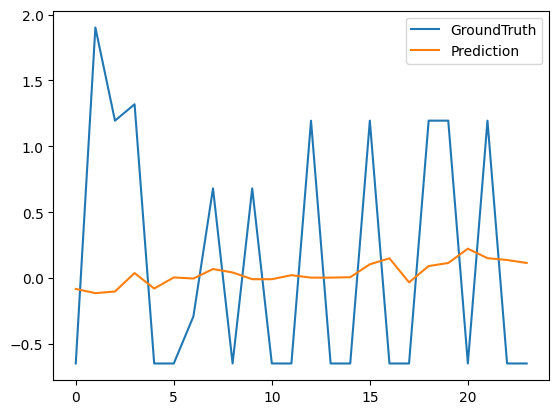

In [195]:
# draw dstip prediction
plt.figure()
plt.plot(trues[0,:,0], label='GroundTruth')
plt.plot(preds[0,:,0], label='Prediction')
plt.legend()
plt.show()